In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D  
from rbf_layer import RBFLayer, l_norm, rbf_gaussian
import traintest as tt
from plot_utils import *
import models
import torch.utils.data as data_utils
import torch.nn.functional as F
import torch.optim as optim
from sklearn import mixture, preprocessing, datasets
from copy import deepcopy
%load_ext skip_kernel_extension
%load_ext autoreload
%autoreload 2

In [2]:
# Generate dataset
data, labels = datasets.make_moons(n_samples=1000, shuffle=True, noise=.15)

df = pd.DataFrame(data, columns=['feature_1', 'feature_2'])
df=(df-df.min())/(df.max()-df.min()) # normalize [0,1]
df['labels'] = labels
data = torch.tensor(df[['feature_1', 'feature_2']].to_numpy(), dtype=torch.float) 
device=torch.device('cuda:0')

<Axes: xlabel='feature_1', ylabel='feature_2'>

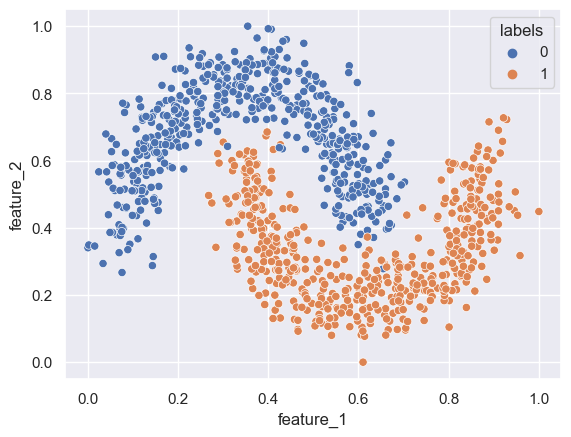

In [3]:
sns.set_theme()
sns.scatterplot(x = df.feature_1, y = df.feature_2, hue = df.labels)

In [4]:
n_centers = 10
gmm = models.GMM(n_centers ,2)
zs = gmm.find_solution(data,iterate=True, collect_z=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [5]:
df2 = pd.DataFrame(gmm.mu.detach(), columns=['feature_1', 'feature_2'])
df2['labels'] = ['gmm_center']*n_centers

In [6]:
# make grid for contour
x = y = np.arange(-.03, 1.03, 0.01)
points = []
for xx in x:
    for yy in y:
        points.append([xx, yy])

<Axes: xlabel='feature_1', ylabel='feature_2'>

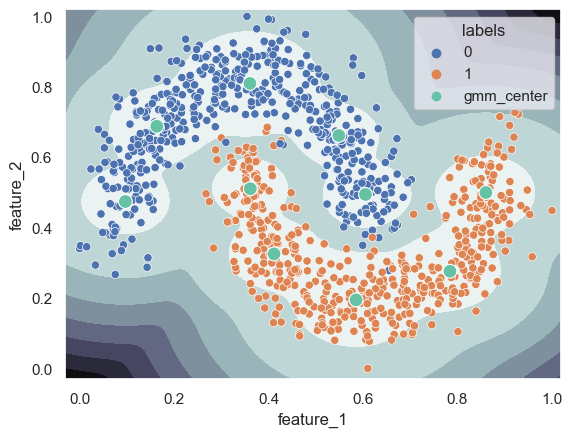

In [7]:
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)
# sns.scatterplot(data = pd.concat([df, df2], axis=0), x = 'feature_1', y = 'feature_2', hue = 'labels')

In [8]:
%%skip True
animate_em(zs,x,y,df)

### MLP Classifier

In [9]:
label = torch.tensor(labels, dtype=torch.int64)
train = data_utils.TensorDataset(data, label)
train_loader = data_utils.DataLoader(train, batch_size=250, shuffle=True)

In [41]:
class TwoMoonsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

lr = 0.1
lr_gmm = 1e-3
decay = 5e-4

net = TwoMoonsNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]
loss = []
acc = []
optimizer = optim.Adam(param_groups)

for epoch in range(200):
    
    l,a,_= tt.train_plain(net.to(device), device, train_loader, optimizer, 
                epoch, verbose=-1)
    loss.append(l)
    acc.append(a)
    if a > .98:
        break # converged

Text(0.5, 0, 'Epoch')

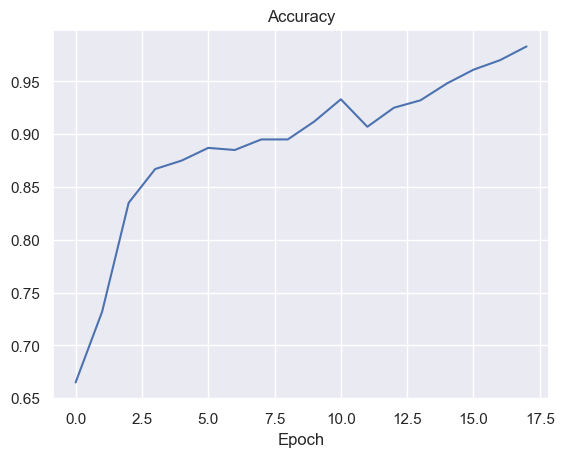

In [42]:
sns.lineplot(acc)
plt.title('Accuracy')
plt.xlabel('Epoch')

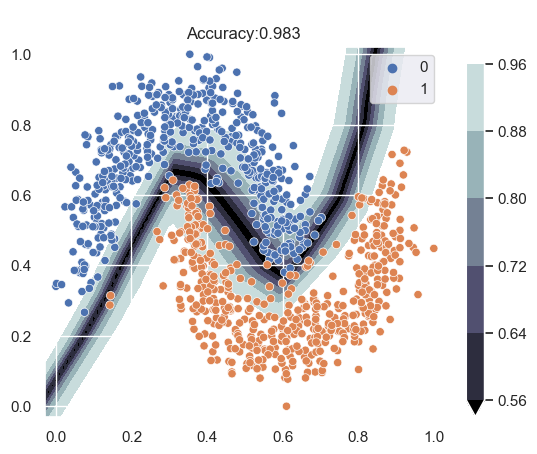

In [43]:
plot_conf(net, data, label, device=device)

### CCU Robust Model Learning

In [44]:
gmm = models.GMM(n_centers ,2)
gmm.find_solution(data,iterate=True)

C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\samle\.conda\envs\CCU\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [45]:
gmm.mu.requires_grad_(False) # turn of learning of centers

Parameter containing:
tensor([[0.5853, 0.1946],
        [0.6053, 0.4941],
        [0.1634, 0.6879],
        [0.8602, 0.4998],
        [0.3606, 0.8098],
        [0.4116, 0.3252],
        [0.7840, 0.2760],
        [0.0969, 0.4742],
        [0.5489, 0.6617],
        [0.3614, 0.5105]])

In [46]:
data_out = torch.rand(1000, 2, dtype=torch.float)
label_out = torch.zeros(1000, dtype=torch.int64)


train_out = data_utils.TensorDataset(data_out, label_out)
train_loader_out = data_utils.DataLoader(train_out, batch_size=250, shuffle=True)

In [47]:
CCU = models.RobustModel(deepcopy(net), deepcopy(gmm), 0.0, dim=2,classes=2)
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

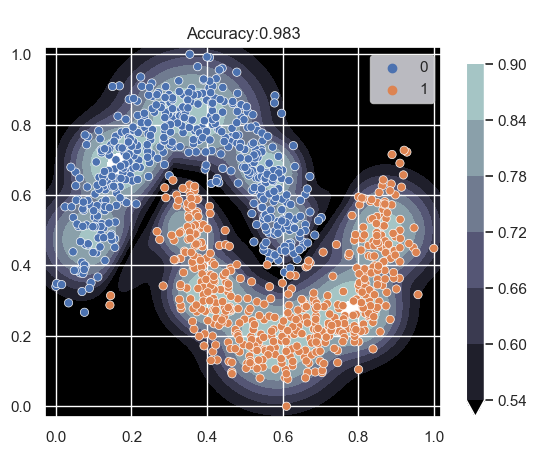

In [48]:
plot_conf(CCU.to(device), data, label, device=device)

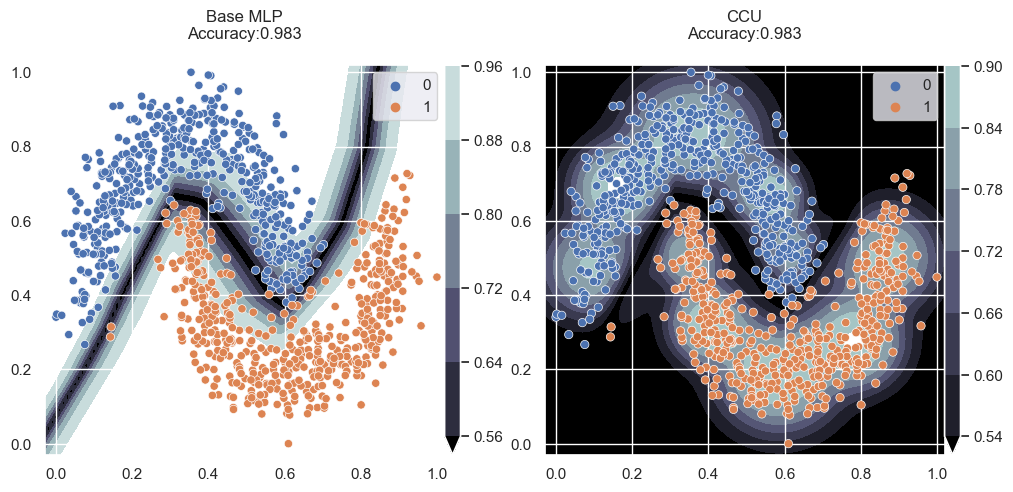

In [49]:
#%%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.87,left=.05,wspace=.25,right=.95)
plot_conf(CCU.base_model.to(device), data, label,
             ax1, device=device, title='Base MLP')
plot_conf(CCU.to(device), data, label,
             ax2, device=device, title='CCU')

# plt.savefig('Base_Vs._CCU_Confidence.png')

## RBFNet Classifier

In [19]:
# Define an RBF layer where the dimensionality of the input feature is 2,
# the number of kernels is 3, and 2 output features

# euclidean norm
def euclidean_norm(x, p=2, dim=-1):
    return torch.norm(x, p=p, dim=dim)


# Gaussian RBF
def rbf_gaussian(x):
    return (-x.pow(2)).exp()


class TwoMoonsRBFNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.rbf = RBFLayer(in_features_dim=2,
                               num_kernels=10,
                               out_features_dim=10,
                               radial_function=rbf_gaussian,
                               norm_function=euclidean_norm,
                               normalization=True)
        self.fc1 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.rbf(x))
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
device=torch.device('cuda:0')

In [20]:
lr = 0.1
decay = 5e-4

net = TwoMoonsRBFNet()
param_groups = [{'params':net.parameters(),'lr':lr, 'weight_decay':decay}]

optimizer = optim.Adam(param_groups)
rbf_tracker = [deepcopy(net.rbf)]
for epoch in range(100):
    tt.train_plain(net.to(device), device, train_loader, optimizer, 
                    epoch, verbose=-1)
    rbf_tracker.append(deepcopy(net.rbf)) # track each step to watch kernels in animation

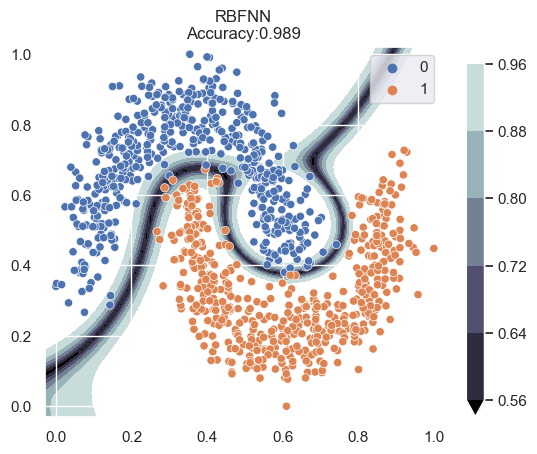

In [21]:
# %%skip True
plot_conf(net, data, label, device=device, title='RBFNN')
# plt.savefig('RBFNN_conf.png')

In [22]:
kernels = net.rbf.get_kernels_centers.data.cpu()
kernels

tensor([[ 0.6189,  0.5106],
        [-0.4404, -0.5107],
        [-0.1315,  0.3993],
        [ 0.3962, -0.7992],
        [-0.3371,  1.1397],
        [ 0.6753, -0.3678],
        [ 1.1060,  0.7769],
        [-0.3180, -0.6050],
        [ 0.6405,  1.0437],
        [ 0.6101, -0.6051]])

<Axes: title={'center': 'Learnt kernels'}, xlabel='feature_1', ylabel='feature_2'>

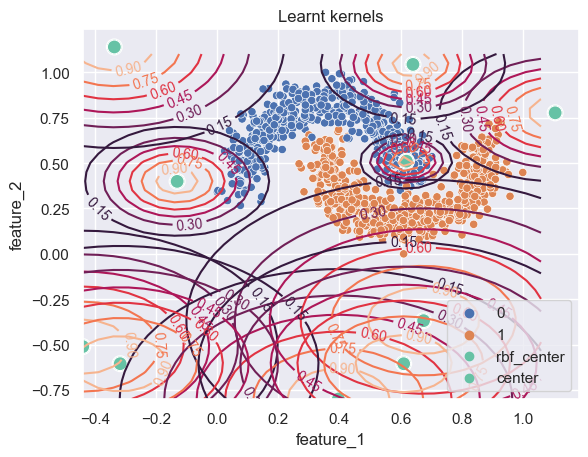

In [23]:
kernel_map(net.rbf, df)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['center']).repeat(len(kernels)))

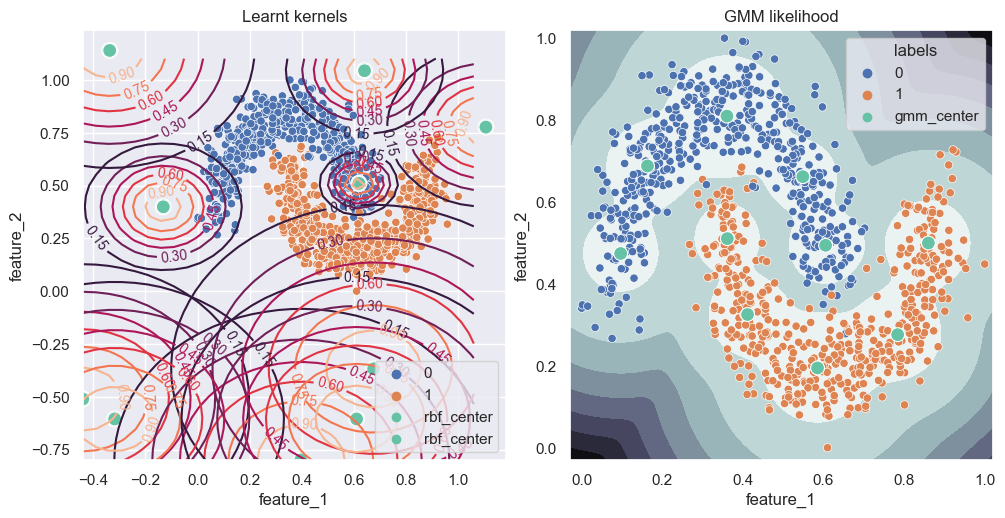

In [24]:
# %%skip True
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plt.subplots_adjust(bottom=.09, top=.95,left=.08,wspace=.15,right=.99)
kernel_map(net.rbf, df, ax = ax1)
sns.scatterplot(x=kernels[:,0], y=kernels[:,1],palette='Set2', s = 100, hue=np.array(['rbf_center']).repeat(len(kernels)), ax=ax1)
z = torch.logsumexp(gmm(torch.tensor(points)), dim=0).detach().view(len(x), len(y)).T
cont = ax2.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels', ax = ax2)
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100, ax = ax2)
ax2.title.set_text(f'GMM likelihood')
# plt.savefig('RBF_Vs_GMM_Centers.png')

In [25]:
%%skip True
animate_rbf(rbf_tracker, df)

## RBF with CCU (with GMM and RBF seperate)

In [26]:
CCU = models.RobustModel(deepcopy(net.to(device)), deepcopy(gmm.to(device)), 0.0, dim=2,classes=2)

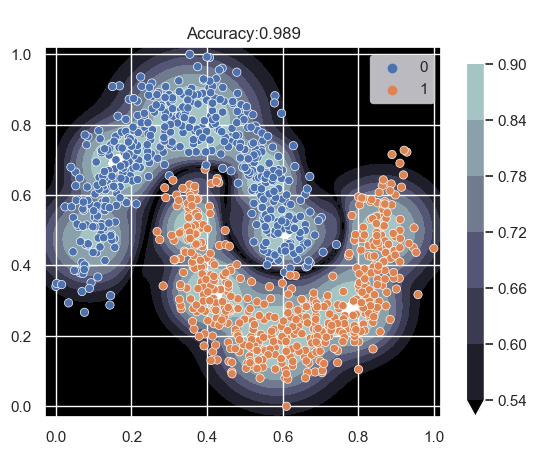

In [27]:
plot_conf(CCU,data, label, device=device)

In [28]:
lr_gmm = 1e-4
param_groups = [{'params':CCU.base_model.parameters(),'lr':lr, 'weight_decay':decay},
               {'params':CCU.mm.parameters(),'lr':lr_gmm, 'weight_decay':0.},
               ] 
loss = []
acc = []
optimizer = optim.Adam(param_groups)

### Compare RBF output to GMM output

In [29]:
sample = torch.tensor([[.4,.4],[.7,.8]])
net.to('cpu')
gmm.to('cpu')

GMM(
  (metric): LpMetric()
)

In [30]:
net.rbf(sample) # rbf has 10 centers, gives distance from each center row wise

tensor([[ 9.5858e-01,  1.8210e-07, -1.9002e-01, -2.2885e-04, -8.9832e-02,
          1.0611e+00, -1.4216e-01, -7.4338e-02,  7.3203e-01,  7.7726e-08],
        [ 1.5501e-01, -2.5805e-06,  6.7564e-01, -8.7697e-05,  2.6683e-01,
          1.6546e-01,  4.7664e-01,  2.1051e-01,  1.2548e-01,  1.7333e-07]],
       grad_fn=<SumBackward1>)

In [31]:
rc = net.rbf.get_kernels_centers
rvar = net.rbf.get_shapes
rw = net.rbf.get_weights

In [32]:
rc

tensor([[ 0.6189,  0.5106],
        [-0.4404, -0.5107],
        [-0.1315,  0.3993],
        [ 0.3962, -0.7992],
        [-0.3371,  1.1397],
        [ 0.6753, -0.3678],
        [ 1.1060,  0.7769],
        [-0.3180, -0.6050],
        [ 0.6405,  1.0437],
        [ 0.6101, -0.6051]])

In [33]:
gmm(sample)# gmm has 10 centers, gives value in column for likelihood of each point from sample

tensor([[ -4.6852, -28.7658],
        [ -8.2003, -17.9935],
        [-18.8686, -42.5399],
        [-20.8946, -10.4036],
        [ -9.4746,  -6.0007],
        [  0.5498, -49.5188],
        [-19.3275, -34.4686],
        [ -9.2604, -48.0785],
        [-19.5576,  -8.1745],
        [ -1.6500, -41.8263]], grad_fn=<SubBackward0>)

In [34]:
gc = gmm.mu.detach()
gvar = gmm.logvar.detach()
gw = gmm.alpha.detach()

In [35]:
gvar.exp()

tensor([0.0063, 0.0026, 0.0034, 0.0050, 0.0078, 0.0030, 0.0039, 0.0048, 0.0021,
        0.0023])

In [36]:
gw.exp()

tensor([0.1593, 0.0735, 0.0937, 0.0918, 0.1971, 0.0849, 0.1033, 0.0733, 0.0685,
        0.0546])

In [37]:
rvar

tensor([9.3753, 2.1623, 4.6005, 1.9278, 2.4818, 1.7750, 3.6579, 2.1258, 4.6063,
        2.0545])

In [38]:
rw.exp()

tensor([[0.7840, 0.9994, 0.7100, 1.1631, 0.7667, 3.1764, 2.6305, 1.0002, 0.7923,
         1.3392],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [2.9032, 1.0320, 3.2915, 0.9222, 3.0363, 0.7435, 0.6965, 1.0227, 3.1783,
         0.8793],
        [0.9999, 1.0000, 1.0004, 1.0000, 0.9999, 0.9997, 0.9998, 1.0000, 1.0000,
         1.0000],
        [1.5675, 1.0054, 1.5938, 0.9839, 1.6514, 0.8704, 0.8276, 1.0109, 1.6110,
         0.9656],
        [0.7662, 0.9948, 0.6806, 1.2027, 0.7462, 3.5847, 2.8658, 1.0024, 0.7716,
         1.4118],
        [2.1307, 1.0197, 2.2895, 0.9548, 2.2391, 0.8023, 0.7590, 1.0178, 2.2815,
         0.9203],
        [1.4437, 1.0036, 1.4425, 0.9881, 1.5009, 0.8919, 0.8558, 1.0088, 1.4610,
         0.9735],
        [0.8244, 0.9999, 0.7773, 1.1097, 0.8064, 2.4229, 2.1240, 0.9995, 0.8407,
         1.2271],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])

<Axes: xlabel='feature_1', ylabel='feature_2'>

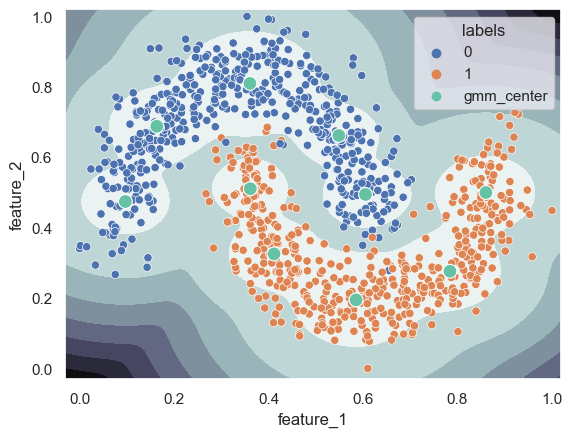

In [39]:
plt.contourf(x,y,z, cmap=plt.cm.bone)
sns.scatterplot(data = df, x = 'feature_1', y = 'feature_2', hue = 'labels')
sns.scatterplot(data = df2, x = 'feature_1', y = 'feature_2', hue = 'labels', palette='Set2', s = 100)

### Combine RBF and GMM centers